In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import PIL

#from utils import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Data preprocessing

In [2]:
data = np.genfromtxt('./train.csv', delimiter=',')
data = np.delete(data, (0), axis=0)
data_np_y = data[:,0]
data = np.delete(data, (0), axis=1)
data_np_x = data / 255


pos = int(data_np_x.shape[0] * 0.9)

train_np_y = data_np_y[:pos]
train_np_x = data_np_x[:pos]
test_np_y = data_np_y[pos:]
test_np_x = data_np_x[pos:]

print ("Y: {}".format(train_np_y[:10]))

Y: [1. 0. 1. 4. 0. 0. 7. 3. 5. 3.]


In [3]:
print (data_np_x.shape, data_np_y.shape)
print (train_np_x.shape, train_np_y.shape)
print (test_np_x.shape, test_np_y.shape)

(42000, 784) (42000,)
(37800, 784) (37800,)
(4200, 784) (4200,)


In [4]:
print (test_np_x.shape, test_np_y.shape)

(4200, 784) (4200,)


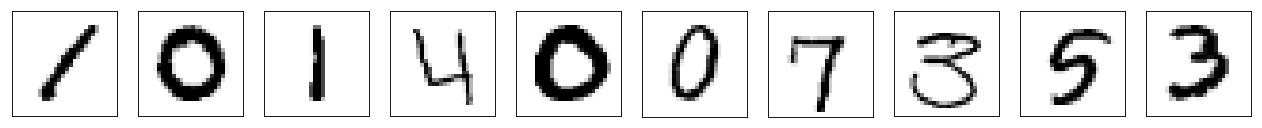

[1. 0. 1. 4. 0. 0. 7. 3. 5. 3.]


In [5]:
fig = plt.figure(figsize=(20,10), dpi=80)
shape = (1,10)
for j in range(10):
    ax = fig.add_subplot(shape[0], shape[1], j+1)
    image = train_np_x[j].reshape(28,28)
    ax.matshow(image, cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

print (train_np_y[:10])

In [6]:
def normalize(x):
    x = (x - 0.1307) / 0.3081    
    return x

In [7]:
train_x = torch.Tensor(np.expand_dims(normalize(train_np_x), axis=1))
train_y = torch.LongTensor(train_np_y)

test_x = torch.Tensor(np.expand_dims(normalize(test_np_x), axis=1))
test_y = torch.LongTensor(test_np_y)

## Neural network

In [8]:
def loader(x, y, batch_size=32):
    for i in range(0, x.size(0) - 1, batch_size):
        data = x[i:i+batch_size]
        if data.shape[0] == batch_size:
            data = data.reshape(batch_size, 1, 28, 28)
            targets = y[i:i+batch_size]

            yield data, targets
    

In [9]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []        
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [10]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [11]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=5e-5, l2=0.):
        super(Net, self).__init__()
        
        
        self._conv1 = ConvLayer([1, 32, 3], bn=batchnorm)
        self._conv2 = ConvLayer([32, 64, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([64*7*7, 512, 10], dropout=dropout)
        
        self.lr = lr
        self.lr_base = lr
        self.l2 = l2
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*7*7)
        x = self.fc(x)
        return x
    
    def loss(self, output, target, **kwargs):        
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [12]:
def shuffle_data(X, y):
    r = np.random.permutation(len(y))
    return X[r], y[r]

In [13]:
def train(epoch, models, log=None):    
    for model in models.values():
        model.lr = model.lr_base * (100 / (epoch + 100))        
        model.optim = optim.Adam(model.parameters(), lr=model.lr, weight_decay=model.l2)
    print ("LR: {}".format(models['bn'].lr))    
    train_size = len(train_x)
    
    for batch_idx, (data, target) in enumerate(loader(train_x, train_y)):        
        for model in models.values():                             
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [14]:
def test(models, log=None):
    test_size = len(test_x)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader(test_x, test_y):
            output = {k: m(data) for k, m in models.items()}           
            for k, m in models.items():     
                #print (output[k].shape, target.shape)
                test_loss[k] += m.loss(output[k], target, size_average=False).item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [15]:
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
 
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

In [16]:
models = {'bn': Net(True), 'drop': Net(False, True), 'bndrop': Net(True, True), 'plain': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [17]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train_x, train_y = shuffle_data(train_x, train_y)    
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_log)

LR: 4.950495049504951e-05
Train Epoch: 1 [0/37800 (0%)]	Losses bn: 2.323382 drop: 2.336625 bndrop: 2.259632 plain: 2.361825
Train Epoch: 1 [6400/37800 (1%)]	Losses bn: 0.919566 drop: 2.106853 bndrop: 1.200318 plain: 1.710013
Train Epoch: 1 [12800/37800 (1%)]	Losses bn: 0.440318 drop: 1.215299 bndrop: 0.621952 plain: 0.793385
Train Epoch: 1 [19200/37800 (2%)]	Losses bn: 0.240221 drop: 0.714859 bndrop: 0.372376 plain: 0.435877
Train Epoch: 1 [25600/37800 (2%)]	Losses bn: 0.104382 drop: 0.482311 bndrop: 0.200921 plain: 0.285753
Train Epoch: 1 [32000/37800 (3%)]	Losses bn: 0.244675 drop: 0.573352 bndrop: 0.310906 plain: 0.460408
Train Epoch: 1 [37792/37800 (3%)]	Losses bn: 0.236456 drop: 0.516539 bndrop: 0.294491 plain: 0.434818


/Users/aleksey/anaconda3/envs/learning/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set:
bn: Loss: 0.1603	Accuracy: 4021.0/4200 (96%)
drop: Loss: 0.3484	Accuracy: 3789.0/4200 (90%)
bndrop: Loss: 0.1852	Accuracy: 3983.0/4200 (95%)
plain: Loss: 0.3183	Accuracy: 3822.0/4200 (91%)

LR: 4.901960784313725e-05
Train Epoch: 2 [0/37800 (0%)]	Losses bn: 0.238083 drop: 0.471508 bndrop: 0.299616 plain: 0.445528
Train Epoch: 2 [6400/37800 (1%)]	Losses bn: 0.164835 drop: 0.413311 bndrop: 0.186913 plain: 0.349515
Train Epoch: 2 [12800/37800 (1%)]	Losses bn: 0.230964 drop: 0.382299 bndrop: 0.313414 plain: 0.344423
Train Epoch: 2 [19200/37800 (2%)]	Losses bn: 0.065044 drop: 0.197598 bndrop: 0.144994 plain: 0.141267
Train Epoch: 2 [25600/37800 (2%)]	Losses bn: 0.067986 drop: 0.220977 bndrop: 0.114234 plain: 0.174761
Train Epoch: 2 [32000/37800 (3%)]	Losses bn: 0.102187 drop: 0.214201 bndrop: 0.129111 plain: 0.213251
Train Epoch: 2 [37792/37800 (3%)]	Losses bn: 0.201521 drop: 0.317748 bndrop: 0.174544 plain: 0.296968
Test set:
bn: Loss: 0.0959	Accuracy: 4060.0/4200 (97%)
drop: Loss

Train Epoch: 10 [32000/37800 (3%)]	Losses bn: 0.059980 drop: 0.054334 bndrop: 0.083307 plain: 0.048129
Train Epoch: 10 [37792/37800 (3%)]	Losses bn: 0.001153 drop: 0.006644 bndrop: 0.003483 plain: 0.005394
Test set:
bn: Loss: 0.0402	Accuracy: 4134.0/4200 (98%)
drop: Loss: 0.0532	Accuracy: 4116.0/4200 (98%)
bndrop: Loss: 0.0433	Accuracy: 4123.0/4200 (98%)
plain: Loss: 0.0509	Accuracy: 4119.0/4200 (98%)

LR: 4.5045045045045046e-05
Train Epoch: 11 [0/37800 (0%)]	Losses bn: 0.001992 drop: 0.042070 bndrop: 0.006470 plain: 0.010844
Train Epoch: 11 [6400/37800 (1%)]	Losses bn: 0.009249 drop: 0.014134 bndrop: 0.009113 plain: 0.008301
Train Epoch: 11 [12800/37800 (1%)]	Losses bn: 0.009882 drop: 0.057983 bndrop: 0.079546 plain: 0.050383
Train Epoch: 11 [19200/37800 (2%)]	Losses bn: 0.046158 drop: 0.131316 bndrop: 0.049899 plain: 0.132836
Train Epoch: 11 [25600/37800 (2%)]	Losses bn: 0.004337 drop: 0.005332 bndrop: 0.013984 plain: 0.004226
Train Epoch: 11 [32000/37800 (3%)]	Losses bn: 0.001216 dr

Train Epoch: 19 [19200/37800 (2%)]	Losses bn: 0.000729 drop: 0.004804 bndrop: 0.002018 plain: 0.000955
Train Epoch: 19 [25600/37800 (2%)]	Losses bn: 0.000846 drop: 0.004303 bndrop: 0.002619 plain: 0.001853
Train Epoch: 19 [32000/37800 (3%)]	Losses bn: 0.018855 drop: 0.028385 bndrop: 0.005876 plain: 0.051768
Train Epoch: 19 [37792/37800 (3%)]	Losses bn: 0.000797 drop: 0.015221 bndrop: 0.001467 plain: 0.008911
Test set:
bn: Loss: 0.0388	Accuracy: 4133.0/4200 (98%)
drop: Loss: 0.0455	Accuracy: 4130.0/4200 (98%)
bndrop: Loss: 0.0427	Accuracy: 4129.0/4200 (98%)
plain: Loss: 0.0387	Accuracy: 4138.0/4200 (99%)

LR: 4.166666666666667e-05
Train Epoch: 20 [0/37800 (0%)]	Losses bn: 0.004063 drop: 0.010223 bndrop: 0.002592 plain: 0.005246
Train Epoch: 20 [6400/37800 (1%)]	Losses bn: 0.002379 drop: 0.016702 bndrop: 0.010013 plain: 0.019044
Train Epoch: 20 [12800/37800 (1%)]	Losses bn: 0.000237 drop: 0.001581 bndrop: 0.001472 plain: 0.000819
Train Epoch: 20 [19200/37800 (2%)]	Losses bn: 0.000338 dro

Train Epoch: 28 [6400/37800 (1%)]	Losses bn: 0.001368 drop: 0.009481 bndrop: 0.000679 plain: 0.008027
Train Epoch: 28 [12800/37800 (1%)]	Losses bn: 0.035717 drop: 0.005933 bndrop: 0.004136 plain: 0.007172
Train Epoch: 28 [19200/37800 (2%)]	Losses bn: 0.006809 drop: 0.013646 bndrop: 0.005620 plain: 0.015892
Train Epoch: 28 [25600/37800 (2%)]	Losses bn: 0.000573 drop: 0.021228 bndrop: 0.008987 plain: 0.023004
Train Epoch: 28 [32000/37800 (3%)]	Losses bn: 0.000871 drop: 0.008439 bndrop: 0.006668 plain: 0.002149
Train Epoch: 28 [37792/37800 (3%)]	Losses bn: 0.003892 drop: 0.007972 bndrop: 0.023261 plain: 0.001805
Test set:
bn: Loss: 0.0423	Accuracy: 4135.0/4200 (98%)
drop: Loss: 0.0344	Accuracy: 4150.0/4200 (99%)
bndrop: Loss: 0.0473	Accuracy: 4132.0/4200 (98%)
plain: Loss: 0.0366	Accuracy: 4142.0/4200 (99%)

LR: 3.875968992248062e-05
Train Epoch: 29 [0/37800 (0%)]	Losses bn: 0.000180 drop: 0.005245 bndrop: 0.015898 plain: 0.004073
Train Epoch: 29 [6400/37800 (1%)]	Losses bn: 0.000247 drop

KeyboardInterrupt: 

In [ ]:
plot_graphs(test_log, 'loss')

In [ ]:
plot_graphs(test_log, 'accuracy')

## Submission

In [ ]:
data = np.genfromtxt('./test.csv', delimiter=',')
data = np.delete(data, (0), axis=0)
data_np_x = data / 255

testing_x = torch.Tensor(np.expand_dims(normalize(data_np_x), axis=1))
testing_y = torch.LongTensor(np.zeros((testing_x.shape[0], 1)))

In [ ]:
print (testing_x.shape)

In [ ]:
answers = np.empty((0, 10))
model = models['drop']
print (model)

for batch_idx, (data, target) in enumerate(loader(testing_x, testing_y)):
    output = model(data)  
    output_np = output.detach().numpy()        
    answers = np.vstack((answers, output_np))
        
print (answers.shape)

In [ ]:
vals = np.argmax(answers, axis=1)

In [ ]:
print (answers[:100])

In [ ]:
print (vals[:1000])

In [ ]:
with open("submission2.txt", "w") as fout:
    fout.write("ImageId,Label\n")
    for i, val in enumerate(vals):
        fout.write("{},{}\n".format(str(i+1), str(val)))
        